This notebook contains two parts. Both parts would generate heatmaps of diseases for input X-ray images.

# Part1 :
    This part would caculate a heapmat with a small red area.

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg
import torch
from torch.utils.data import Dataset
from skimage.color import gray2rgb
import cv2
from torchvision import transforms, utils
from skimage import io, transform
from torch.utils.data import DataLoader
import torchvision.models as models
import time
from torch.autograd import Variable
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image
from torch import nn,optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dset
import argparse
import math
#import setproctitle
import shutil
import sys

%matplotlib inline

In [2]:
!pwd

/home/deyingk/Documents/LabProjects/Xray/codes


In [3]:
## set path before running 

In [4]:
# val_label_path = '/mnt/data/deyingk/xRay/data/labels_split_choice_2/val.csv'
# test_label_path = '/mnt/data/deyingk/xRay/data/labels_split_choice_2/test.csv'
# auroc_save_path = "/home/deyingk/projects/Xray/split_choice2/Mdf_lossfun/"
# weight_load_path= '/mnt/data/deyingk/xRay/data/no_oversample_weight_lsc2/mdfLossFun/'


#This is on gru
# val_label_path = '/mnt/data/deyingk/xRay/data/labels/val.csv'
# test_label_path = '/mnt/data/deyingk/xRay/data/labels/test.csv'
# auroc_save_path = "/home/deyingk/projects/Xray/orig_lossfun/upsampling_1/"
# weight_load_path= '/mnt/data/deyingk/xRay/data/resampled_trained_weight_1/origLossFun/'


val_label_path = '/home/deyingk/Documents/LabProjects/Xray/codes/origResizeAndCrop/val.csv'
test_label_path = '/home/deyingk/Documents/LabProjects/Xray/codes/origResizeAndCrop/test.csv'
weight_load_path= '/home/deyingk/Documents/LabProjects/Xray/data/weights/weights_ResizeAndCrop/'
img_dir = '/home/deyingk/Documents/LabProjects/Xray/images/'


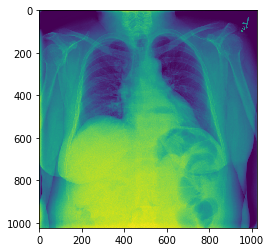

In [5]:
img=mpimg.imread(img_dir+'00006624_000.png')
imgplot = plt.imshow(img)
plt.show()

1.resize&color normalization 2.detection(bounding box)

# The heatmap starts in the following

In [6]:
import pickle
densenet_chosen = pickle.load(open(weight_load_path+'densenet_epoch_17.pkl', 'rb'))
densenet_chosen.eval()

DataParallel(
  (module): DenseNet(
    (features): Sequential(
      (conv0): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm.1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
          (relu.1): ReLU(inplace)
          (conv.1): Conv2d (64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm.2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
          (relu.2): ReLU(inplace)
          (conv.2): Conv2d (128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm.1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
          (relu.1): ReLU(inplace)
          (conv.1): Conv2d 

In [7]:
import io
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2

In [8]:
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

In [9]:
densenet = densenet_chosen
if (str(type(densenet))=="<class 'torch.nn.parallel.data_parallel.DataParallel'>"):
    print(1)
    densenet=densenet._modules.get('module')

densenet._modules.get('features').register_forward_hook(hook_feature)

1


In [10]:
#densenet

In [11]:
# get the softmax weight
params = list(densenet.parameters())

In [12]:
weight_softmax = np.squeeze(params[-2].data.cpu().numpy())

In [13]:
normalize = transforms.Normalize(
    mean = [0.49139968, 0.48215827, 0.44653124],
    std = [0.24703233, 0.24348505, 0.26158768]
)
preprocess = transforms.Compose([
    transforms.Scale((256,256)),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    #normalize
])

/home/deyingk/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


In [14]:
img = Image.open(img_dir+'00004519_003.png').convert('RGB')
#print np.array(img).shape
img_tensor_before_norm = preprocess(img)

to_image = transforms.ToPILImage()

img_cropped = to_image(img_tensor_before_norm)

img_tensor=normalize(img_tensor_before_norm)
img_variable = Variable(img_tensor.unsqueeze(0).cuda())
logit = densenet(img_variable)
#print(logit)

h_x = F.softmax(logit).data.squeeze()
probs, idx = h_x.sort(0, True)

#print(idx)

/home/deyingk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


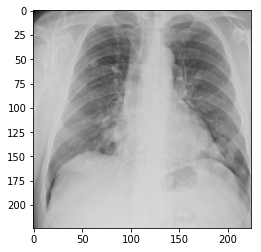

In [15]:
plt.imshow(img_cropped)

In [16]:
feature_conv = features_blobs[0]

size_upsample = (224, 224)
bz, nc, h, w = feature_conv.shape

class_idx = [idx[0]]
class_idx=idx[0]
#class_idx=0

In [17]:
cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))

In [18]:
weight_softmax[class_idx].shape

(1024,)

In [19]:
feature_conv.reshape((nc, h*w)).shape

(1024, 49)

In [20]:
cam = cam.reshape(h, w)
cam = cam - np.min(cam)

In [21]:
cam

array([[  7.115345  ,  10.24077034,  11.04864502,   7.58975983,
          3.33628201,   0.81540424,   0.        ],
       [ 10.89759445,  24.54816628,  23.88004494,  13.70896149,
          5.21802425,   3.28301263,   0.59877551],
       [ 14.65055943,  29.96461868,  30.1813755 ,  20.46689796,
         12.37829018,  14.60929871,  10.11676598],
       [ 11.56928158,  22.48438644,  23.54236603,  21.12633133,
         22.00178337,  34.43832397,  25.98469734],
       [  5.50374508,  13.76928902,  16.09757042,  18.37473488,
         24.38126564,  39.30176163,  26.86391068],
       [  1.58147907,   7.15914631,   6.7108345 ,   9.05908298,
         16.08099556,  24.43385887,  17.70670891],
       [  1.28533292,   3.73815465,   3.37610078,   5.59416199,
          8.15224075,   6.34514523,   3.71752   ]], dtype=float32)

In [22]:

cam_img_pre = cam / np.max(cam)
cam_img_pre

array([[ 0.18104392,  0.26056772,  0.2811234 ,  0.193115  ,  0.08488887,
         0.02074727,  0.        ],
       [ 0.27728006,  0.62460726,  0.60760748,  0.34881291,  0.1327682 ,
         0.08353347,  0.01523533],
       [ 0.37277105,  0.76242429,  0.76793951,  0.52076286,  0.31495509,
         0.37172121,  0.25741252],
       [ 0.29437056,  0.57209617,  0.59901553,  0.53754157,  0.55981672,
         0.87625396,  0.66115856],
       [ 0.14003813,  0.35034788,  0.40958902,  0.46752954,  0.62036061,
         1.        ,  0.68352944],
       [ 0.04023939,  0.18215841,  0.1707515 ,  0.23050068,  0.40916729,
         0.6216988 ,  0.4505322 ],
       [ 0.03270421,  0.09511418,  0.08590202,  0.14233871,  0.20742686,
         0.16144684,  0.09458914]], dtype=float32)

In [23]:
cam_img_pre=cam_img_pre
cam_img_pre[cam_img_pre<0.95]=0
cam_img_pre

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

In [24]:
cam_img = np.uint8(255 * cam_img_pre)
cam_img

array([[  0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 255,   0],
       [  0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0]], dtype=uint8)

In [25]:
CAMs=cv2.resize(cam_img, size_upsample)
CAMs[112]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3,
       3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [26]:
#CAMs = np.uint8(255*((CAMs/255)**5))
CAMs[112]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3,
       3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [27]:
height, width,_=  np.array(img_cropped).shape

heatmap = cv2.applyColorMap(cv2.resize(CAMs,(width, height)), cv2.COLORMAP_JET)

In [28]:
heatmap[:,:,2][112]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [29]:
result = heatmap * 0.3 + np.array(img_cropped) * 0.6
cv2.imwrite('CAM_00006819_004.jpg', result)

True

Populating the interactive namespace from numpy and matplotlib


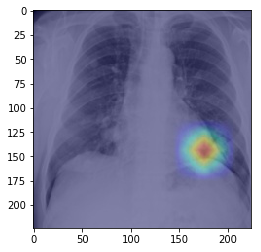

In [30]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img_plt_cam=mpimg.imread('CAM_00006819_004.jpg')
imgplot = plt.imshow(img_plt_cam)
plt.show()
plt.gcf().clear()


# Part2 :
    The following would caculate a heapmat with larger red area.

In [32]:
import io
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2

# input image

# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

#In case that densenet is of DataParallel structure.
densenet = densenet_chosen
if (str(type(densenet))=="<class 'torch.nn.parallel.data_parallel.DataParallel'>"):
    densenet=densenet._modules.get('module')

densenet._modules.get('features').register_forward_hook(hook_feature)

# get the softmax weight
params = list(densenet.parameters())
weight_softmax = np.squeeze(params[-2].data.cpu().numpy())
#print weight_softmax

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    #print bz, nc, h, w
    
    output_cam = []
    for idx in class_idx:
        
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam
normalize = transforms.Normalize(
   mean = [0.49139968, 0.48215827, 0.44653124],
    std = [0.24703233, 0.24348505, 0.26158768]
)
preprocess = transforms.Compose([
   transforms.Scale((224,224)),
   transforms.ToTensor(),
   normalize
])




img = Image.open(img_dir+'00006819_003.png').resize((224,224)).convert('RGB')
#print np.array(img).shape
img_tensor = preprocess(img)
img_variable = Variable(img_tensor.unsqueeze(0).cuda())
logit = densenet(img_variable)


h_x = F.softmax(logit).data.squeeze()


probs, idx = h_x.sort(0, True)

print(idx)

# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# render the CAM and output
height, width, _ =  np.array(img).shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + np.array(img) * 0.5
cv2.imwrite('CAM_00006819_003.jpg', result)


  8
 10
  4
  2
 11
  9
  0
 13
 12
  6
  5
  3
  1
  7
[torch.cuda.LongTensor of size 14 (GPU 0)]



/home/deyingk/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
/home/deyingk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


True

In [33]:
!ls

CAM_00006819_003.jpg	   origResize_Rotate3_Crop
CAM_00006819_004.jpg	   origResize_Rotate_Crop
cam_debug.ipynb		   small_region_heatmap.ipynb
mdfLossFunResizeAndCrop    split2_upsam2_orgLsFun_rotate
NewModel		   split2_upsam2_orgLsFun_xtransl_15
NewNewModel		   split2_upsam2_orgLsFun_xtransl_5
NewNewModel _3_stages	   test
NewNewModel _combineTrain  Untitled.ipynb
origResizeAndCrop


Populating the interactive namespace from numpy and matplotlib


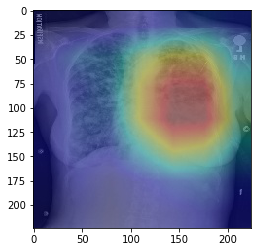

In [34]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('CAM_00006819_003.jpg')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
224/7